In [1]:
import os
import sys
import torch
sys.path.append('../scripts')
from helper import load_models, prepare_for_combined_usage
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
corr_method = "spearman"

In [3]:
rsa_mat = torch.load(f"/home/lciernik/projects/divers-priors/results_local/rsa_correlation_{corr_method}/imagenet_subset_10k/rsa_distance_matrix.pt")

In [4]:
dataset = 'imagenet-subset-10k'

In [5]:
models, n_models = load_models('../scripts/models_config.json')
model_names, sources, model_parameters, module_names = prepare_for_combined_usage(models)
models = zip(model_names, sources, model_parameters, module_names)

In [6]:
def _get_model_id(model, model_parameters):
    if not model_parameters:
        return model
    model_slug = model
    model_suffix = model_parameters.get("variant", "")
    if model_suffix:
        model_slug = f"{model_slug}_{model_suffix}"
    model_suffix = model_parameters.get("dataset", "")
    if model_suffix:
        model_slug = f"{model_slug}_{model_suffix}"
    return model_slug

In [7]:
# Get model ids
model_ids = [_get_model_id(model[0], model[2]) for model in models]
model_ids = [(model_id + '-' + dataset).replace('/', '_') for model_id in model_ids]

In [8]:
feature_root="/home/space/diverse_priors/features"
split='train'
model_ids = sorted(
        [mid for mid in model_ids if os.path.exists(os.path.join(feature_root, mid, f'features_{split}.pt'))])
model_ids = [mid.replace(f"-{dataset}", "") for mid in model_ids]

In [9]:
df = pd.DataFrame(rsa_mat.numpy(), index=model_ids, columns=model_ids)

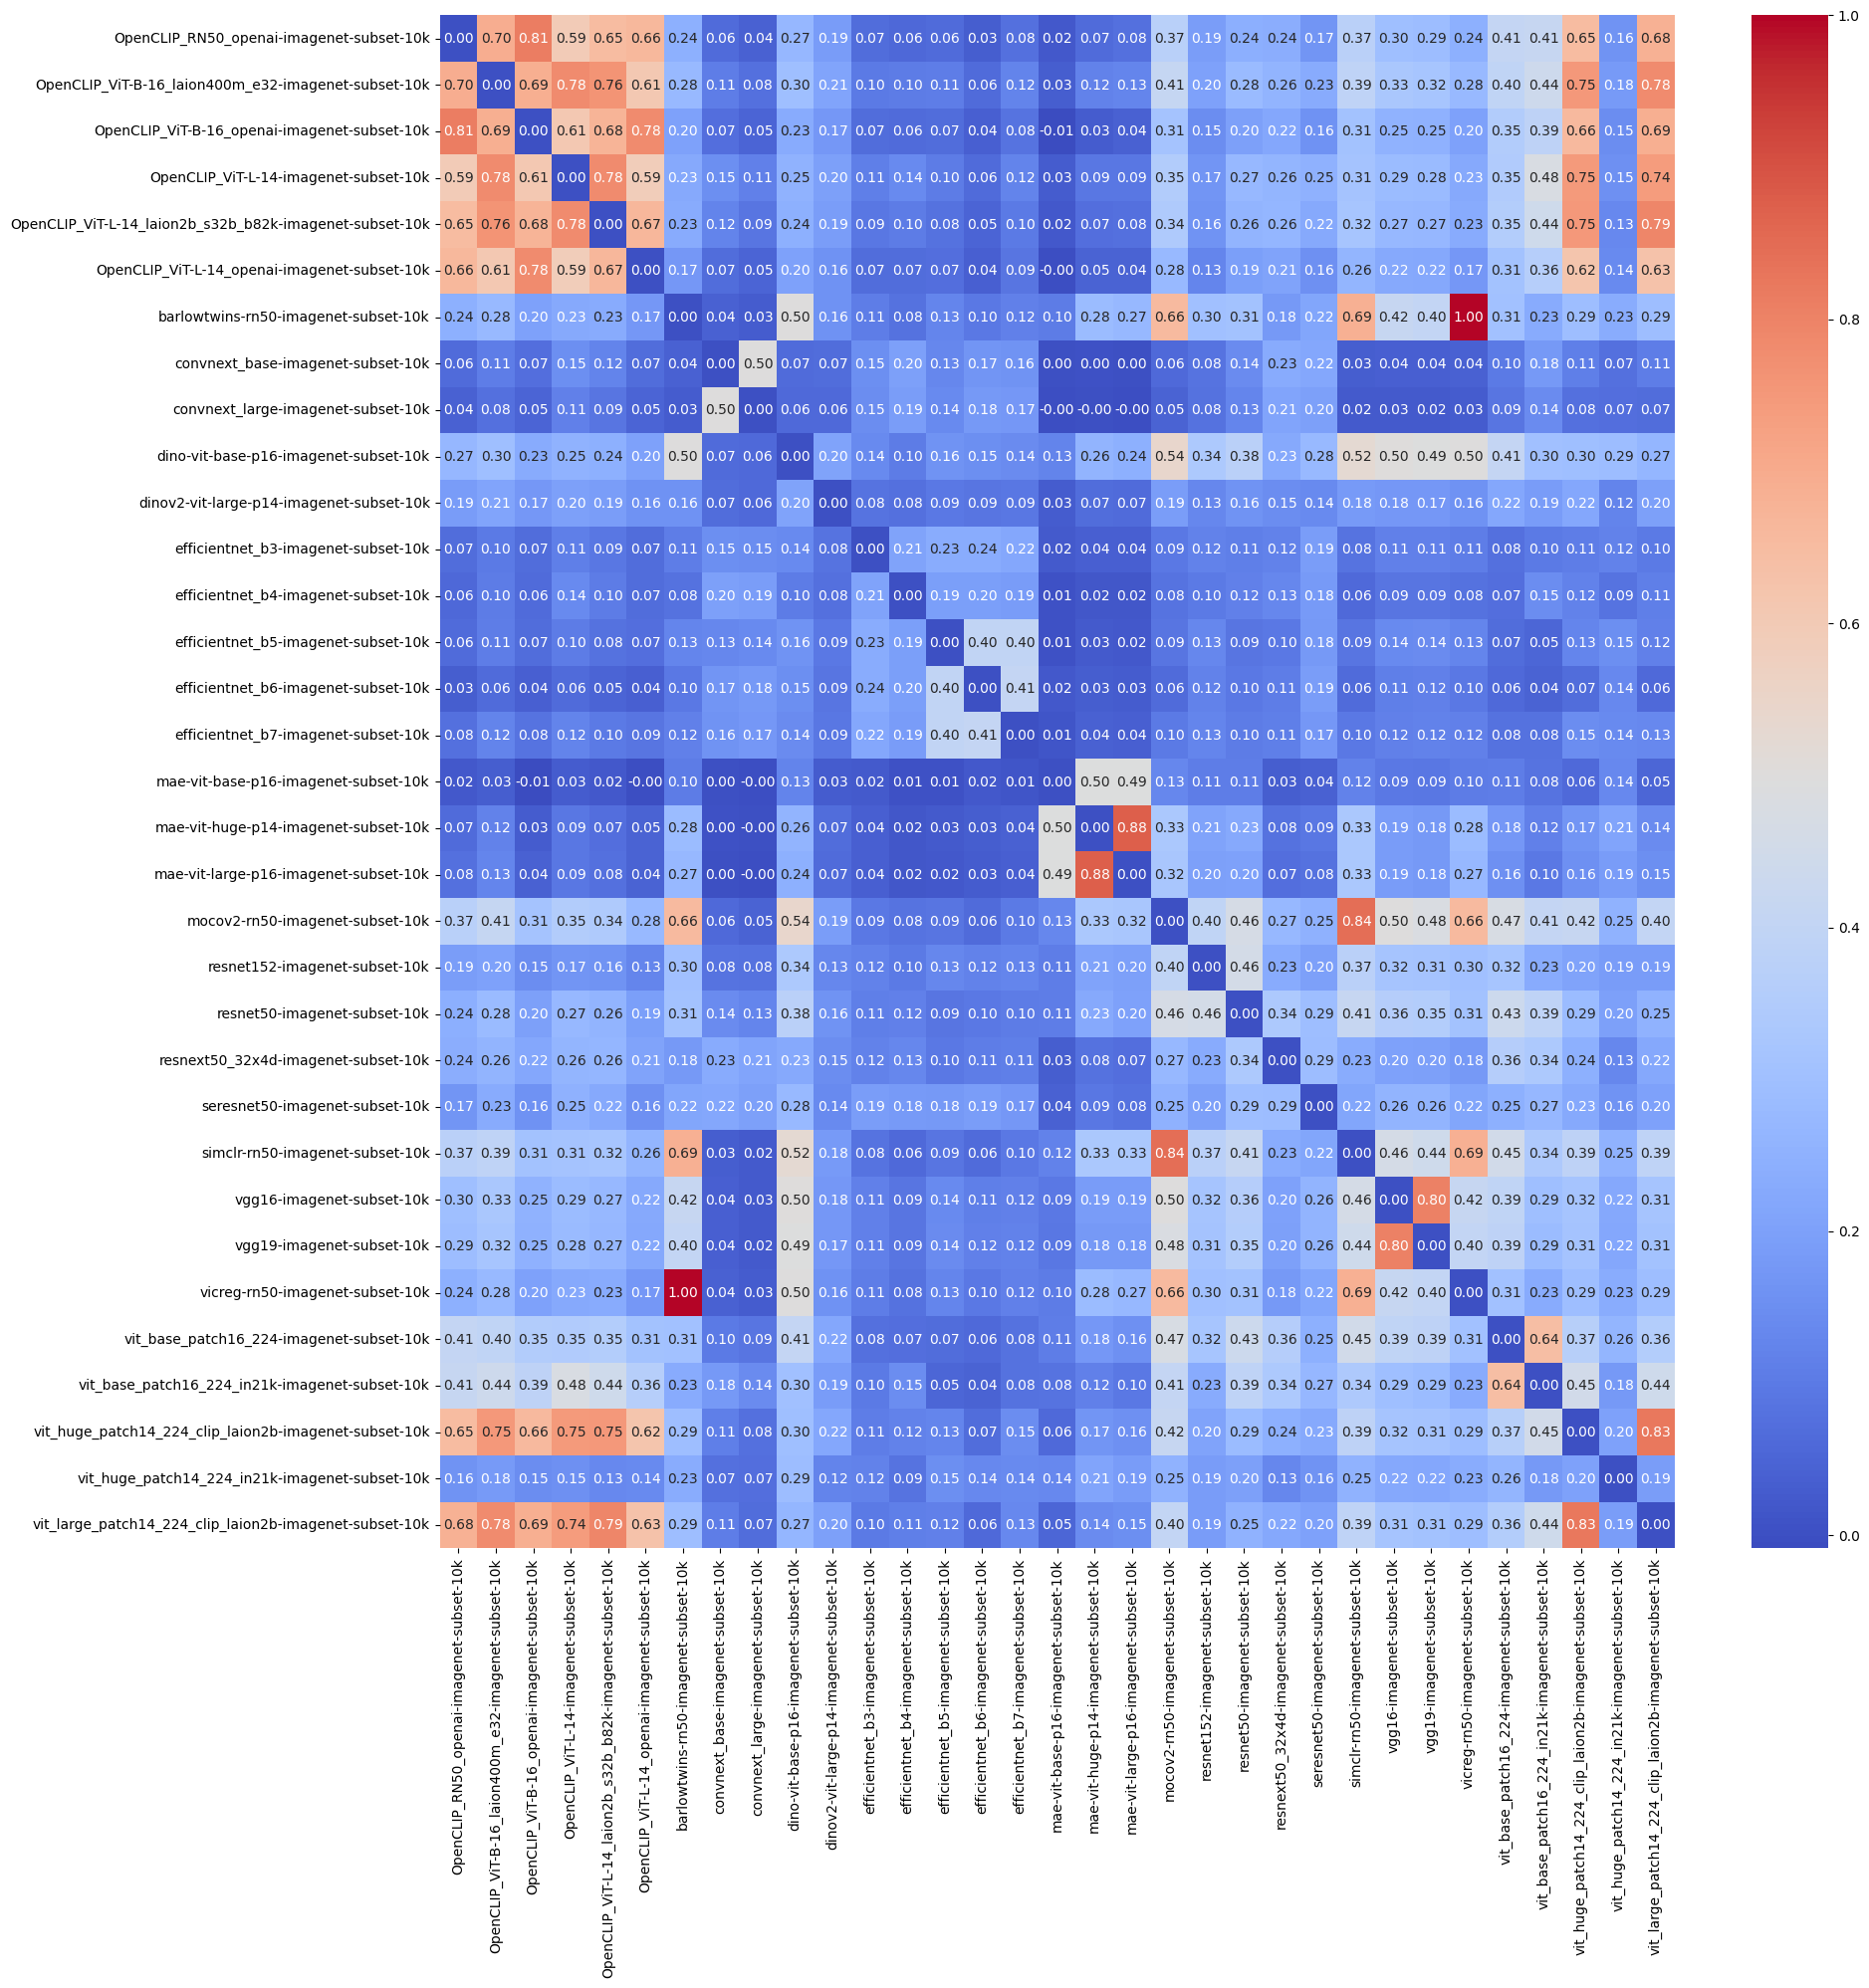

In [17]:
plt.figure(figsize=(15,15))
g = sns.heatmap(df, cmap='coolwarm', annot=True, fmt='.2f')
g.set_title(f"{dataset.upper()} RSA {corr_method} correlation")
plt.savefig(f'heatmap_model_rsa_{corr_method}.pdf', format='pdf')

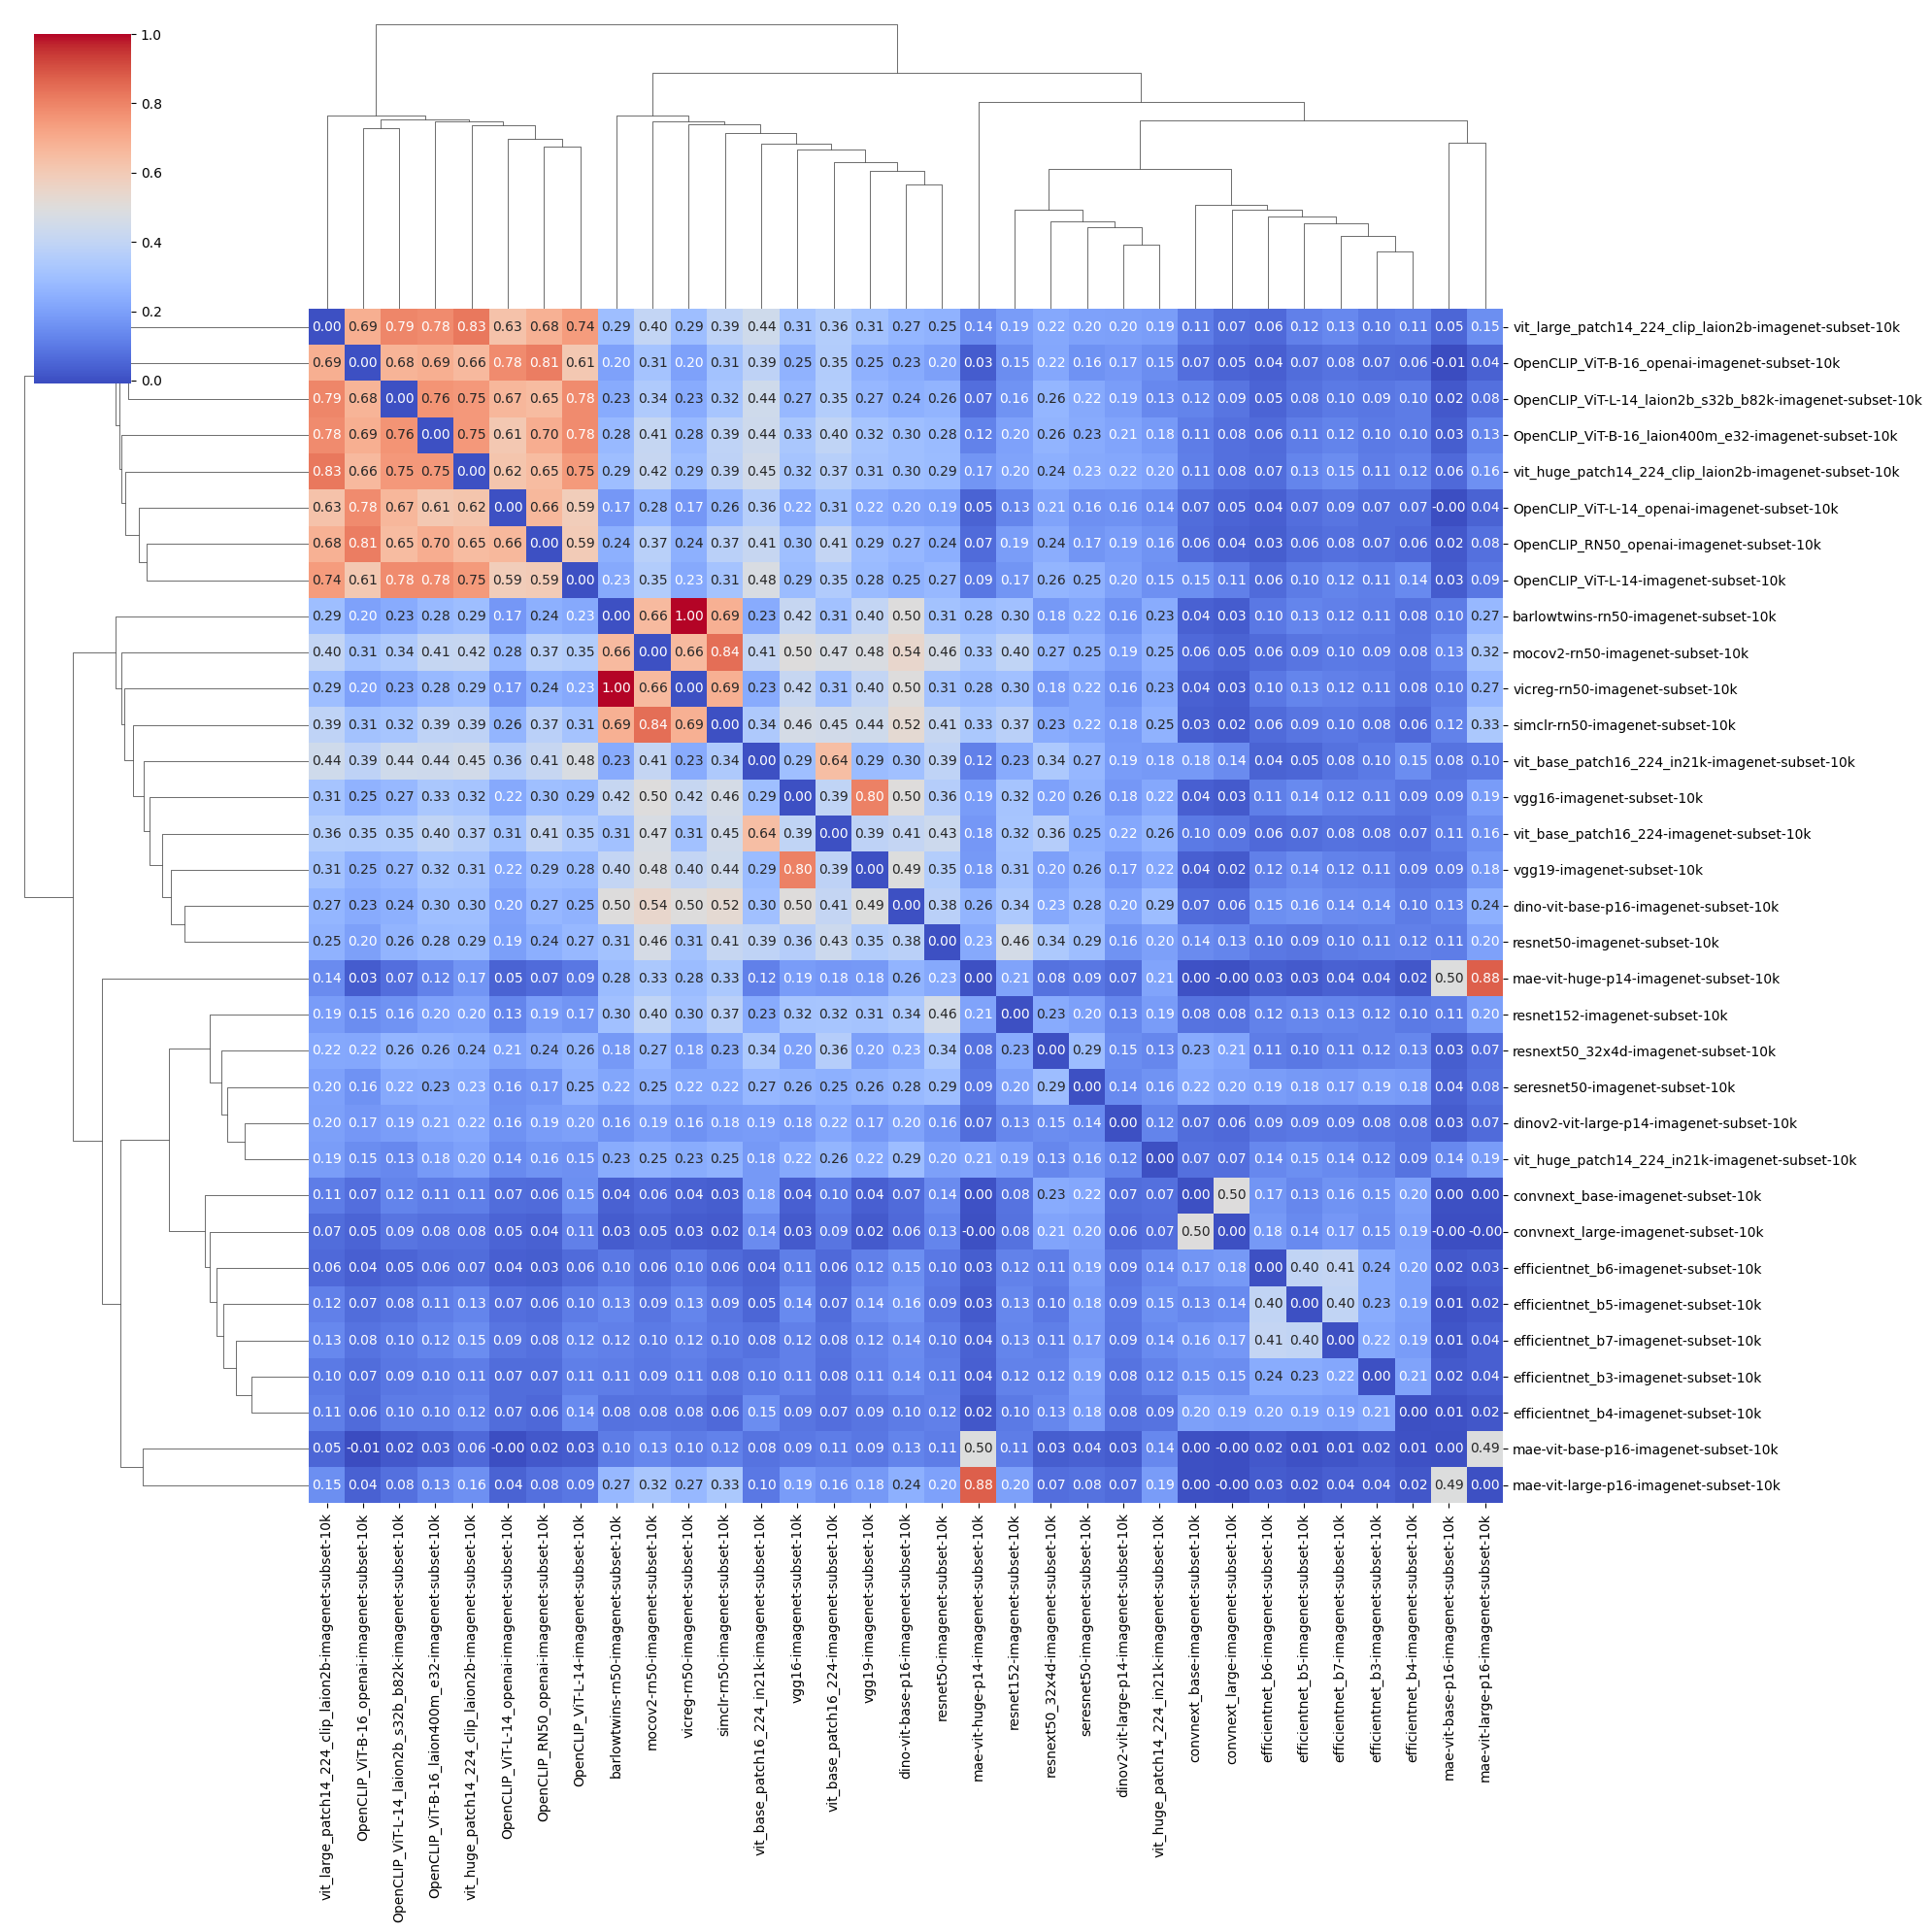

In [10]:
sns.clustermap(df, cmap='coolwarm', annot=True, fmt='.2f', figsize=(20,20))
g.set_title(f"{dataset.upper()} RSA {corr_method} correlation")
plt.savefig(f'dendogram_model_rsa_{corr_method}.pdf', format='pdf')

In [10]:
affinity_mat = df.copy().abs()

In [11]:
np.fill_diagonal(affinity_mat.values, 1)

In [12]:
dissimilarity_mat = (1 - affinity_mat)

In [13]:
from sklearn.cluster import SpectralClustering, AffinityPropagation 
from sklearn.manifold import TSNE, MDS
import textwrap

In [14]:
affinity_mat_embedded_tsne = TSNE(n_components=2, 
                                  learning_rate='auto', 
                                  init='random', 
                                  perplexity=30,
                                  metric='precomputed').fit_transform(dissimilarity_mat.values)

In [15]:
dissim_mat_embedded_mds = MDS(n_components=2, 
                              normalized_stress='auto', 
                              dissimilarity='precomputed').fit_transform(dissimilarity_mat.values)

In [16]:
df_pred = pd.DataFrame(index=df.index).reset_index()

In [17]:
clustering = SpectralClustering(n_clusters=4,
                                affinity='precomputed',
                                assign_labels='discretize',
                                random_state=0)

df_pred['spec_labels'] = clustering.fit_predict(affinity_mat.values, y=None)                         

In [18]:
clustering = AffinityPropagation(damping=0.75,
                                 affinity='precomputed',
                                 random_state=5)


df_pred['aff_labels'] = clustering.fit_predict(affinity_mat.values, y=None)  

In [19]:
group_models_spec = df_pred.groupby('spec_labels').index.unique()
group_models_aff = df_pred.groupby('aff_labels').index.unique()

In [20]:
lbl_spec = group_models_spec.apply(lambda x: '\n'.join(textwrap.wrap(', '.join(x), width=50)))
lbl_aff = group_models_aff.apply(lambda x: '\n'.join(textwrap.wrap(', '.join(x), width=50)))

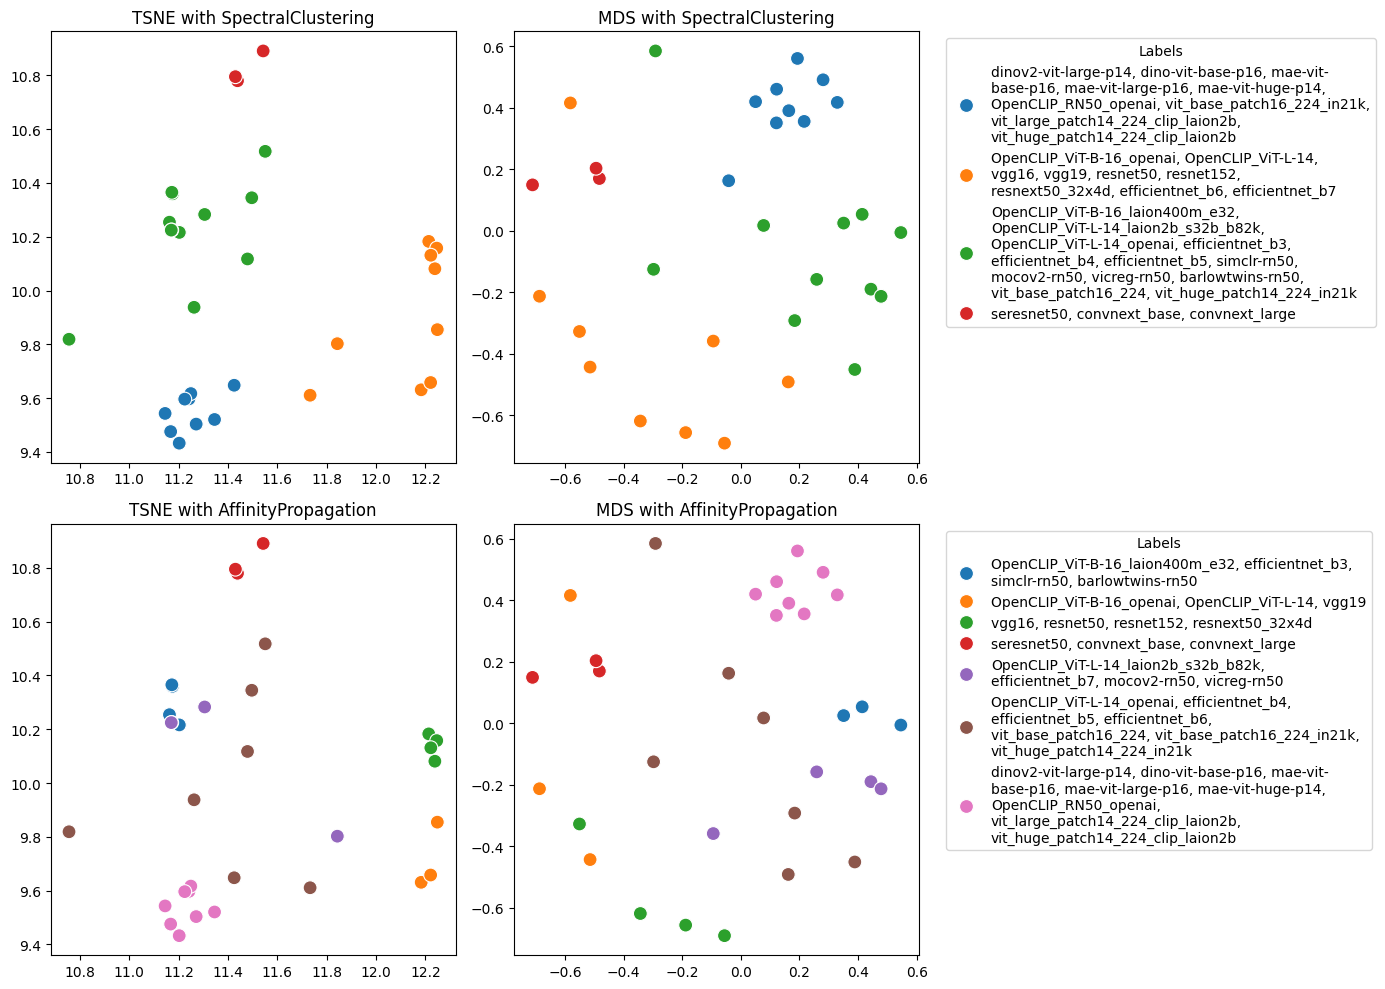

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
sns.scatterplot(
    x = affinity_mat_embedded_tsne[:,0],
    y = affinity_mat_embedded_tsne[:,1],
    hue = df_pred['spec_labels'],
    palette = 'tab10',
    ax=axs[0, 0],
    legend=False,
    s=100
)
axs[0,0].set_title('TSNE with SpectralClustering')

sns.scatterplot(
    x = dissim_mat_embedded_mds[:,0],
    y = dissim_mat_embedded_mds[:,1],
    hue = df_pred['spec_labels'],
    palette = 'tab10',
    ax=axs[0, 1],
    s=100
)
axs[0, 1].set_title('MDS with SpectralClustering')

sns.scatterplot(
    x = affinity_mat_embedded_tsne[:,0],
    y = affinity_mat_embedded_tsne[:,1],
    hue = df_pred['aff_labels'],
    palette = 'tab10',
    ax=axs[1, 0],
    legend=False,
    s=100
)
axs[1,0].set_title('TSNE with AffinityPropagation')
sns.scatterplot(
    x = dissim_mat_embedded_mds[:,0],
    y = dissim_mat_embedded_mds[:,1],
    hue = df_pred['aff_labels'],
    palette = 'tab10',
    ax=axs[1, 1],
    s=100
)
axs[1, 1].set_title('MDS with AffinityPropagation')

for ax in axs[:,1].flat:
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    legend_labels = lbl_spec if ax in axs[0,:] else lbl_aff
    legend.set_title('Labels')
    for i, label in legend_labels.items():
        legend.get_texts()[i].set_text(f"{label}")
fig.suptitle(f"{dataset.upper()} RSA {corr_method} correlation clustering")
plt.tight_layout()
plt.savefig(f'scatter_plots_clusters_rsa_{corr_method}.pdf', format='pdf')